# AMPSphere v.2022-03

This is a notebook meant to form the set of notebooks used to analyze the data in AMPSphere and write the manuscript:

__AMPSphere: Global survey of prokaryotic antimicrobial peptides shaping microbiomes__

### GMGC v.1 homolog c_AMPs 

Here, we show how c_AMPs from AMPSphere are aligned to homolog large proteins from GMGC, their features and
distribution.


In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from itertools import combinations
from scipy.stats import kruskal, mannwhitneyu

plt.rcParams['svg.fonttype'] = 'none'

In [2]:
# loading data
gmgc = pd.DataFrame()
for record in pd.read_table('../data_folder/result_gmgc.m8.xz',
                            header=None,
                            chunksize=1_000_000):
    gmgc = pd.concat([gmgc, record])

gmgc.columns = ['query', 'target', 'evalue',
                'gapopen', 'pident', 'nident', 
                'qstart', 'qend', 'qlen',
                'tstart', 'tend', 'tlen',
                'alnlen', 'raw', 'bits',
                'cigar', 'qseq', 'tseq',
                'qheader', 'theader', 'qaln',
                'taln', 'qframe', 'tframe',
                'mismatch', 'qcov', 'tcov']

In [3]:
# creating some measures
# make zero-based
gmgc['tstart'] -= 1
# fix for macrel initial methionine deletion
gmgc.loc[gmgc.tstart == 1, 'tstart'] = 0
gmgc['pct_start'] = gmgc['tstart'] * 100 / gmgc['tlen']
gmgc['pct_end'] = gmgc['tend'] * 100 / gmgc['tlen']
gmgc['pct_amp'] = (1 + gmgc.qend - gmgc.qstart)*100 / gmgc.qlen

In [5]:
# histogram of pct_start
gmgc = gmgc.sort_values(
    by=['evalue', 'bits', 'pident'],
    ascending=[True, False, False]
)
                                                                                                                                                                                                                                            
df = gmgc.groupby('query').head(1)

# df.to_csv('filtered_gmgc_homologs.tsv.gz', sep='\t', header=True, index=None)

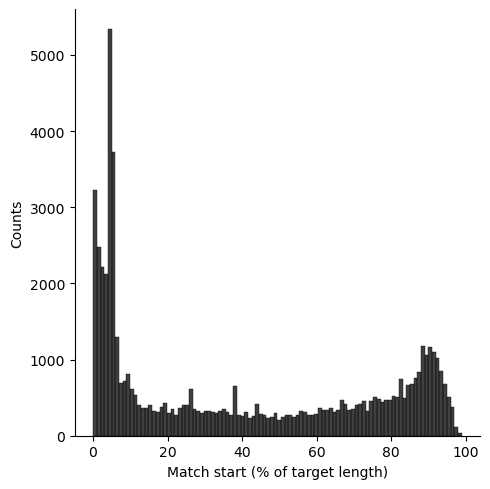

In [6]:
sns.displot(data=df,
            x='pct_start',
            bins=100, 
            color='black')

plt.xlabel('Match start (% of target length)')
plt.ylabel('Counts')
plt.show()

In [7]:
f = df[(df.pct_start <= 25)|(df.pct_start >= 75)]
f = len(f) * 100 / len(df)

print(f'{f:.2}% of hits begin in the initial or final 25% of target protein')

7.3e+01% of hits begin in the initial or final 25% of target protein


## Enrichment of ortholog groups among the homologs

In [8]:
data = pd.read_table('../data_folder/adjust_significant_function.csv.xz',
                     sep='\t',
                     header='infer')

data = data[['eggnog_OG',
             'count_AMP',
             'count_GMGC',
             'times',
             'p_adjust']]

data.columns = ['EggNOG ortholog group',
                'Counts in the homologs of c_AMPs',
                'Counts in the redundant GMGC',
                'Enrichment (fold)',
                'Adjusted P-value']

e5 = pd.read_table('../data_folder/e5_annotations.tsv.gz', 
                  sep='\t',
                  header=None)

e5.columns = ['tax',
              'EggNOG ortholog group',
              'class',
              'function']

e5 = e5[['EggNOG ortholog group',
         'class',
         'function']].drop_duplicates()

e5.drop('function', axis=1, inplace=True)
e5 = e5.drop_duplicates()
k = e5['EggNOG ortholog group'].value_counts()
k = k[k==1]
e5 = e5[e5['EggNOG ortholog group'].isin(k.index)]

In [9]:
print('Working with OGs')

x = data.merge(on='EggNOG ortholog group',
               right=e5)

cmap = {'S': ('Unknown function', (43/255, 142/255, 112/255, 255/255)),
        'L': ('Replication, recombination,\nand repair', (190/255, 99/255, 29/255, 255/255)),
        'J': ('Translation, ribosomal\nstructure, and biogenesis', (124/255, 120/255, 171/255, 255/255)),
        'K': ('Transcription', (101/255, 149/255, 47/255, 255/255)),
        'C': ('Energy production\nand conversion', (207/255, 65/255, 138/255, 255/255)),
        '-': ('Other', (202/255, 157/255, 30/255, 255/255))}

x['class'] = x['class'].apply(lambda x: x if x in cmap else '-')
x['class'] = x['class'].apply(lambda x: cmap.get(x)[0])

a = x['class'].value_counts() * 100 / len(x)
print(a)

a, b = min(x['Enrichment (fold)']), max(x['Enrichment (fold)'])
print(f'Minimum enrichment was {a}-fold, and the maximum was {b}-fold')

cutoff = 1000
n = len(x[x['Enrichment (fold)'] < cutoff])
n = n*100/len(x)
print(f'{n:.2f}% of OGs were enriched less than {cutoff}-fold')

x.rename({'class': 'Functional class'}, axis=1, inplace=True)

x = x[x['Enrichment (fold)'] >= 1.5]
x = x[x['Adjusted P-value'] < 0.05]

x.to_csv('suppTableS3.tsv',
         sep='\t',
         header=True,
         index=None)

x

Working with OGs
Unknown function                                     38.824705
Other                                                36.344406
Replication, recombination,\nand repair               8.754271
Transcription                                         5.451080
Energy production\nand conversion                     5.413887
Translation, ribosomal\nstructure, and biogenesis     5.211651
Name: class, dtype: float64
Minimum enrichment was 0.0291568346922574-fold, and the maximum was 585797.255010816-fold
91.45% of OGs were enriched less than 1000-fold


,EggNOG ortholog group,Counts in the homologs of c_AMPs,Counts in the redundant GMGC,Enrichment (fold),Adjusted P-value,Functional class
0,COG3547,1356,3326230,23.881123,0.00000,"Replication, recombination,\nand repair"
1,1VKBK,244,4072,3510.180015,0.00000,Unknown function
2,24UUY,243,4064,3502.675516,0.00000,Unknown function
3,2C6KI,244,4072,3510.180015,0.00000,Unknown function
4,33J10,244,4072,3510.180015,0.00000,Unknown function
...,...,...,...,...,...,...
3787,1NSR6,2,89,1316.398326,0.04992,Unknown function
3788,2AJ03,2,89,1316.398326,0.04992,Unknown function
3789,2UR2W,2,89,1316.398326,0.04992,Unknown function
3790,319I4,2,89,1316.398326,0.04992,Unknown function


In [10]:
a = x.groupby('Functional class').agg('size')
b = x[x['Counts in the homologs of c_AMPs'] <= 10].groupby('Functional class').agg('size')
c = x[x['Counts in the homologs of c_AMPs'] <= 5].groupby('Functional class').agg('size')
d = pd.concat([a, b, c], axis=1)
d.columns = ['c > 10', '5 < c <= 10', 'c <= 5']
d *= -1
d = d.reset_index()
d = d.melt(id_vars='Functional class')
order = ['Unknown function',
         'Translation, ribosomal\nstructure, and biogenesis',
         'Replication, recombination,\nand repair',
         'Other',
         'Energy production\nand conversion',
         'Transcription']
d = pd.concat([d[d['Functional class'] == w] for w in order])
d

,Functional class,variable,value
5,Unknown function,c > 10,-2041
11,Unknown function,5 < c <= 10,-1589
17,Unknown function,c <= 5,-1139
4,"Translation, ribosomal\nstructure, and biogenesis",c > 10,-299
10,"Translation, ribosomal\nstructure, and biogenesis",5 < c <= 10,-168
16,"Translation, ribosomal\nstructure, and biogenesis",c <= 5,-115
2,"Replication, recombination,\nand repair",c > 10,-429
8,"Replication, recombination,\nand repair",5 < c <= 10,-272
14,"Replication, recombination,\nand repair",c <= 5,-170
1,Other,c > 10,-757


## Plot 2CA

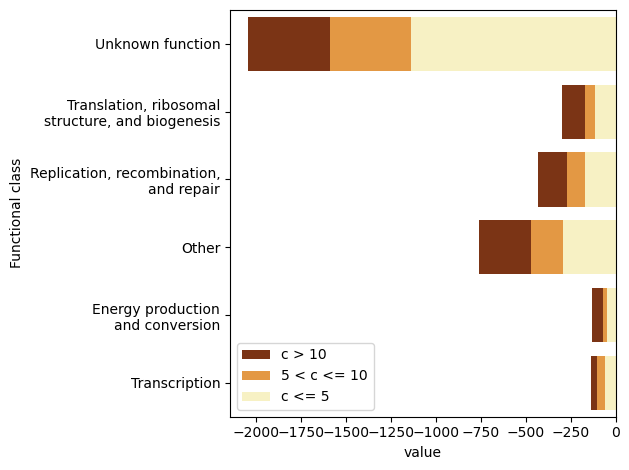

In [11]:
colors = {'c > 10': (140/255, 45/255, 4/255),
          '5 < c <= 10': (254/255, 153/255, 41/255),
          'c <= 5': (255/255, 247/255, 188/255)}
          
for w in colors:
    sns.barplot(data=d[d['variable'] == w],
                y='Functional class',
                x='value',
                color=colors[w],
                label=w)

plt.legend()
plt.tight_layout()
#plt.savefig('2C.svg')
plt.show()
plt.close()

## Plot 2CB

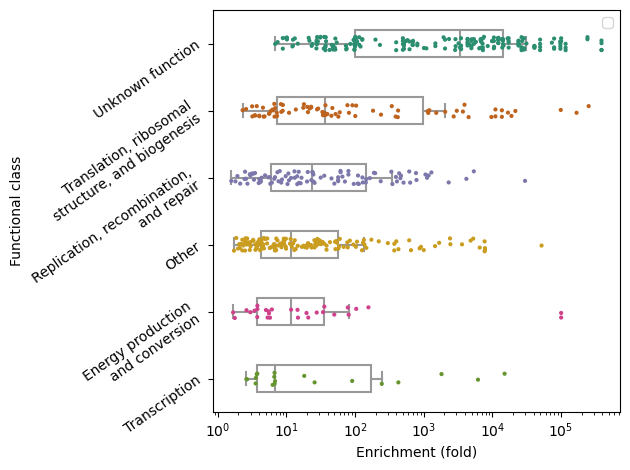

In [12]:
f1 = (x['Counts in the homologs of c_AMPs'] >= 20)
f2 = (x['Counts in the homologs of c_AMPs'] >= 20)
x = x[f1 & f2]

order = x.groupby('Functional class')
order = order['Enrichment (fold)'].quantile([0.5])
order = order.sort_values(ascending=False).index
order = [y[0] for y in order]

cmap = {'Unknown function': (43/255, 142/255, 112/255, 255/255),
        'Translation, ribosomal\nstructure, and biogenesis': (190/255, 99/255, 29/255, 255/255),
        'Replication, recombination,\nand repair': (124/255, 120/255, 171/255, 255/255),
        'Other': (202/255, 157/255, 30/255, 255/255),
        'Energy production\nand conversion': (207/255, 65/255, 138/255, 255/255),
        'Transcription': (101/255, 149/255, 47/255, 255/255)}

sns.boxplot(data=x,
            y='Functional class',
            x='Enrichment (fold)',
            color='white',
            width=0.4,
            showfliers=False,
            order=order)

sns.stripplot(data=x,
              y='Functional class',
              x='Enrichment (fold)',
              s=3,
              palette=cmap,
              order=order)

plt.xscale('log')
plt.yticks(rotation=35)
plt.legend('')
plt.tight_layout()
#plt.savefig('fig2D.svg')
plt.show()

## Statistical testing of enrichment and abundance

In [13]:
print('Test of c_AMP homolog counts for each OG')
c = x.groupby('Functional class').apply(lambda w: w['Counts in the homologs of c_AMPs'].tolist())
_, p = kruskal(*c)
print(f'Kruskal result: p={p:.2E}')

print('Paired:')
print('category1\tcategory2\tP-value')
for i, j in combinations(c.index, 2):
    _, pp = mannwhitneyu(c[i], c[j])
    if pp < 0.05: print(f'{i}\t{j}\t{pp}')

print('Test of c_AMP enrichment')
c = x.groupby('Functional class').apply(lambda w: w['Enrichment (fold)'].tolist())
_, p = kruskal(*c)
print(f'Kruskal result: p={p:.2E}')

print('Paired:')
print('category1\tcategory2\tP-value')
for i, j in combinations(c.index, 2):
    _, pp = mannwhitneyu(c[i], c[j])
    if pp < 0.05: print(f'{i}\t{j}\t{pp}')

Test of c_AMP homolog counts for each OG
Kruskal result: p=6.23E-03
Paired:
category1	category2	P-value
Other	Replication, recombination,
and repair	0.014345836363616339
Replication, recombination,
and repair	Unknown function	8.578757082467855e-05
Test of c_AMP enrichment
Kruskal result: p=2.66E-39
Paired:
category1	category2	P-value
Energy production
and conversion	Translation, ribosomal
structure, and biogenesis	0.006624170191256602
Energy production
and conversion	Unknown function	1.4574888925833935e-10
Other	Translation, ribosomal
structure, and biogenesis	0.0003892102991387651
Other	Unknown function	5.756498248634909e-33
Replication, recombination,
and repair	Unknown function	3.5674031094911266e-21
Transcription	Unknown function	5.227606336239328e-07
Translation, ribosomal
structure, and biogenesis	Unknown function	7.834700402532458e-12
